### Условие задачи

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### 1. Загрузка данных.

In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2 , f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, auc , roc_curve
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [6]:
# Путь к файлам проекта
PATH = r"D:\YandexDisk\DS\Project_Final\Final_project"
#PATH ='/datasets/final_provider/' 

# Записываем датасеты в переменные
df_contract = pd.read_csv(os.path.join(PATH,'contract.csv'))
df_internet = pd.read_csv(os.path.join(PATH,'internet.csv'))
df_personal = pd.read_csv(os.path.join(PATH,'personal.csv'))
df_phone = pd.read_csv(os.path.join(PATH,'phone.csv'))

**Анализ пропусков**

##### Данные по договорам

In [7]:
df_contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [8]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


##### Данные по использованию интернета

In [9]:
df_internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [10]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


##### Данные по абонентам

In [11]:
df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


##### Данные по использованию телефона

In [13]:
df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [14]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


____
**Анализ дубликатов**

##### Данные по договорам

In [15]:
#  Проверка наличия дубликатов
df_contract.duplicated().sum()

0

##### Данные по использованию интернета

In [16]:
#  Проверка наличия дубликатов
df_internet.duplicated().sum()

0

##### Данные по абонентам

In [17]:
#  Проверка наличия дубликатов
df_personal.duplicated().sum()

0

##### Данные по использованию телефона

In [18]:
#  Проверка наличия дубликатов
df_phone.duplicated().sum()

0

### Выводы:
1. **Contract**. Пропусков и дубликатов нет. Необходимо заменить тип данных в столбцах *BeginDate, EndDate* на **DateTime** и столбца *TotalCharges* на **float**.
2. **Internet**. Пропусков и дубликатов нет. Тип данных соответствует содержанию. Для использования в модели бинарные значения будут преобразованы в 0 и 1.
3. **Personal**. Пропусков и дубликатов нет. Тип данных соответствует содержанию. Непонятен смысл столбцов *SeniorCitizen, Partner, Dependents*.
4. **Phone**. Пропусков и дубликатов нет. Тип данных соответствует содержанию.
 


## 2.  Подготовка данных к анализу


___
**Замена типа данных**

Даты заменяем на тип данных  Datetime.
Для неушедших клиентов указываем дату выгрузки данных.

In [19]:
# Преобразование типа данных
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

#Замена Enddate для неушедших клиентов

df_contract.loc[df_contract['EndDate'] == 'No','EndDate'] = '2020-02-01'
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'] , errors = 'coerce')

In [20]:
# Проверим пропуски при замене типа данных
df_contract[df_contract['TotalCharges'].isna()]

customerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           NaN  
753                Mailed check           20.25           NaN  
936                Mailed check           80.85           NaN  
1082               Mailed check           25.75           NaN  
1340    Credit card (automatic)           56.05           NaN  
3331               Mailed check           19.85           NaN  
3826               Mailed check           25.35           NaN  
4380               Mailed check           20.00           NaN  
5218               Mailed check           19.70           NaN  
6670               Mailed check           73.35           NaN  
6754  Bank transfer (automatic)           61.90           NaN

In [21]:
# Проверим какие значения у других новых клиентов
df_contract[df_contract['BeginDate']=='2020-02-01']

customerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           NaN  
753                Mailed check           20.25           NaN  
936                Mailed check           80.85           NaN  
1082               Mailed check           25.75           NaN  
1340    Credit card (automatic)           56.05           NaN  
3331               Mailed check           19.85           NaN  
3826               Mailed check           25.35           NaN  
4380               Mailed check           20.00           NaN  
5218               Mailed check           19.70           NaN  
6670               Mailed check           73.35           NaN  
6754  Bank transfer (automatic)           61.90           NaN

После замены значения "No" на дату и замены типа данных образуются пропуски в столбце TotalCharges, который заменяем на соответствующее значения  MonthlyCharges.

In [22]:
# Заполнение пропусков после преобразования чисел

# Список индексов строк с пропусками
new_client_charge_ind = df_contract[df_contract['TotalCharges'].isna()]['MonthlyCharges'].index

# Заполнение пропусков
for index in new_client_charge_ind:
    df_contract.loc[index,'TotalCharges'] = df_contract.loc[index,'MonthlyCharges'] 

Проверяем типы данных:

In [23]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


___
**Ушедшие клиенты**

Проверяем количество ушедших клиентов:

In [24]:
df_gone = df_contract[df_contract['EndDate'] != '2020-02-01']
df_gone.head(5)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
2   3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
4   9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
5   9305-CDSKC 2019-03-01 2019-11-01  Month-to-month              Yes   
8   7892-POOKP 2017-07-01 2019-11-01  Month-to-month              Yes   
13  0280-XJGEX 2015-09-01 2019-10-01  Month-to-month              Yes   

                PaymentMethod  MonthlyCharges  TotalCharges  
2                Mailed check           53.85        108.15  
4            Electronic check           70.70        151.65  
5            Electronic check           99.65        820.50  
8            Electronic check          104.80       3046.05  
13  Bank transfer (automatic)          103.70       5036.30

In [25]:
print('Всего ушедших клиентов:', len(df_gone))

Всего ушедших клиентов: 1869


#### Выводы по подготовке данных:
1. Изменен тип данных дат. В столбце EndDate для неушедших клиентов значение заменено на дату актуализации датасета для дальнейшего учета длительности контракта.
2. Изменен тип данных стоимости на float.
3. Определено количество ушедших клиентов.

    

## План работы:
1. Определить целевой признак.
    - Клиент ушел - 1 (1869 клиентов)
    - Клиент не уходит - 0 (5174 клиентов);
2. Подготовить данные для анализа влияния признаков на целевой признак. Провести исследовательский анализ (EDA). 
3. Определить признаки, которые будут использоваться для обучения модели. 
4. Определить состав обучающей и тестовой выборок. 
5. Определить метрики. 
6. Обучить модели и выбрать одну модель.
7. Предсказать уход клиента, определить метрики на тестовых данных.
8. Сделать выводы и подготовить отчет.

## Вопросы:
1. Что означают признаки *SeniorCitizen	Partner	Dependents*?
2. Есть ли дополнительные данные о клиентах? Возраст? Образование? Работа и т.д.?


## 3. Исследовательский анализ данных

___
**Выделение целевого признака**

Ушедших клиентов маркируем 1, неушедших - 0:

In [26]:
# Добавляем целевой признак
df_contract.loc[df_contract['EndDate']=='2020-02-01', 'Churn'] = 0
df_contract.loc[df_contract['EndDate']!='2020-02-01', 'Churn'] = 1
df_contract['Churn'] = df_contract['Churn'].astype('int')

In [27]:
df_contract.groupby('Churn').count()['customerID']

Churn
0    5174
1    1869
Name: customerID, dtype: int64

**Анализ количественных данных: абонентской, суммарной платы клиента и времени жизни клиента**

In [28]:
# Для удобства выделим переменные с клиентами
gone_client = df_contract[df_contract['Churn']==1]
still_client = df_contract[df_contract['Churn']==0]

Функиця для рисования гистограмм распределения платы.

In [29]:
def hist(df_gone, df_still, column):
    ax = plt.figure(figsize = (12,7))
    sns.distplot(df_gone[column] , bins= 50 , kde=False , color = 'red');
    sns.distplot(df_still[column] , bins= 50 , kde=False );
    ax.legend(labels=['gone_client','still_client']) 
    plt.title(column);

*MonthlyCharges*

In [30]:
print('Статистика ежемесячной платы ушедших клиентов')
gone_client['MonthlyCharges'].describe()

Статистика ежемесячной платы ушедших клиентов


count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [31]:
print('Статистика ежемесячной платы действующих клиентов')
still_client['MonthlyCharges'].describe()

Статистика ежемесячной платы действующих клиентов


count    5174.000000
mean       61.265124
std        31.092648
min        18.250000
25%        25.100000
50%        64.425000
75%        88.400000
max       118.750000
Name: MonthlyCharges, dtype: float64

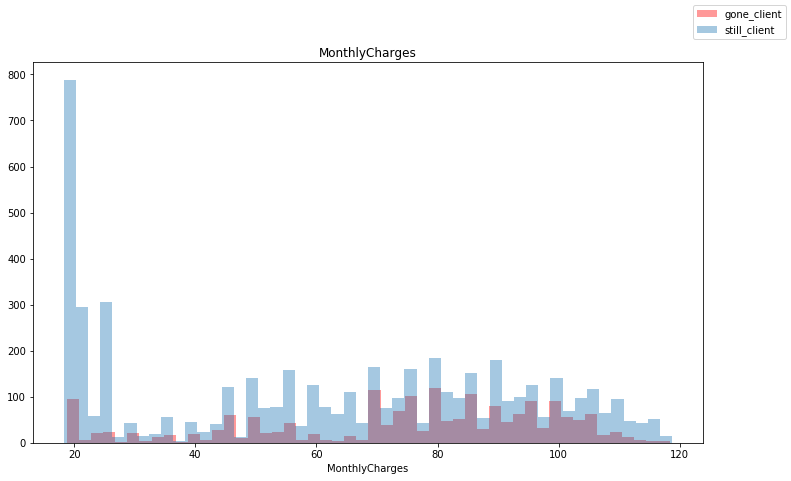

In [32]:
# Распределение абонентской платы
hist(gone_client, still_client, 'MonthlyCharges')

*TotalCharges*

In [33]:
print('Статистика суммарной платы ушедших клиентов')
gone_client['TotalCharges'].describe()

Статистика суммарной платы ушедших клиентов


count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64

In [34]:
print('Статистика суммарной платы действующих клиентов')
still_client['TotalCharges'].describe()

Статистика суммарной платы действующих клиентов


count    5174.000000
mean     2549.999497
std      2329.858843
min        18.800000
25%       572.900000
50%      1679.525000
75%      4262.850000
max      8672.450000
Name: TotalCharges, dtype: float64

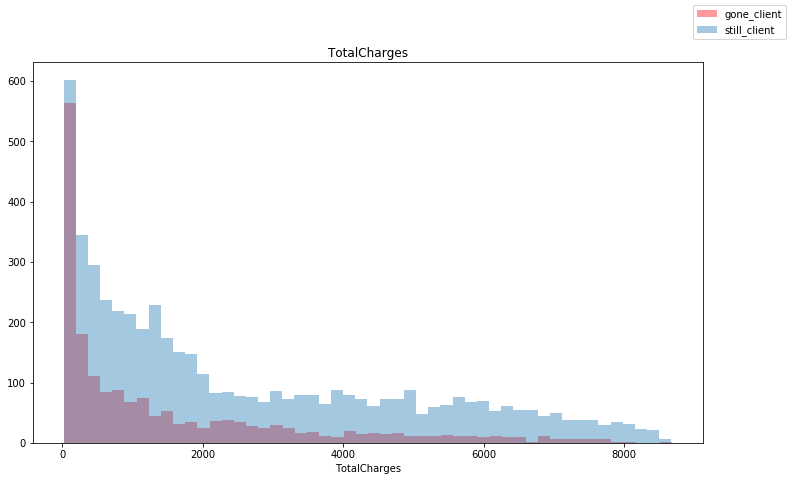

In [35]:
# Распределение суммарной платы
hist(gone_client, still_client , 'TotalCharges')

**Время жизни клиента**

In [36]:
# Добавляем столбец в датасет в днях
df_contract['lifetime'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days.astype('int')
df_contract

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7038  6840-RESVB 2018-02-01 2020-02-01        One year              Yes   
7039  2234-XADUH 2014-02-01 2020-02-01        One year              Yes   
7040  4801-JZAZL 2019-03-01 2020-02-01  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  lifetime  
0              Electronic check           29.85         29.85      0        31  
1                  Mailed check           56.95       1889.50      0      1036  
2                  Mailed check           53.85        108.15      1        61  
3     Bank transfer (automatic)           42.30       1840.75      0      1371  
4              Electronic check           70.70        151.65      1        61  
...                         ...             ...           ...    ...       ...  
7038               Mailed check           84.80       1990.50      0       730  
7039    Credit card (automatic)          103.20       7362.90      0      2191  
7040           Electronic check           29.60        346.45      0       337  
7041               Mailed check           74.40        306.60      1       123  
7042  Bank transfer (automatic)          105.65       6844.50      0      2010  

[7043 rows x 10 columns]

In [37]:
# Для удобства выделим переменные с клиентами
gone_client = df_contract[df_contract['Churn']==1]
still_client = df_contract[df_contract['Churn']==0]

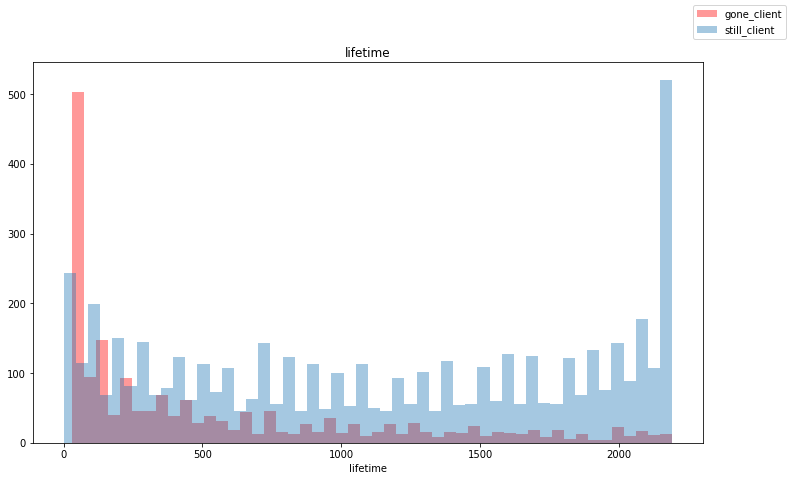

In [38]:
# Распределение времени жизни ушедших клиентов 
hist(gone_client , still_client , 'lifetime')

Вывод по распределению времени жизни:
- большАя часть клиентов уходит после пары месяцев от заключения договора. Примерно такое же количество среди действующих давних клиентов.
- распределение ушедщих и не ушедших клиентов различается, что показывает значительное влияние на целевой признак.

**Графики зависимости между количественными признаками**

In [39]:
df_num = df_contract[['MonthlyCharges' , 'TotalCharges', 'lifetime', 'Churn']]


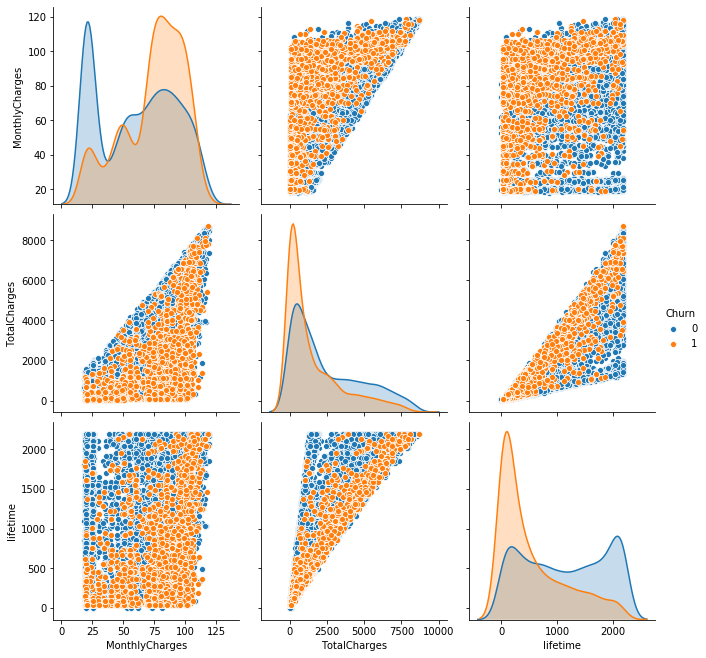

In [40]:
sns.pairplot(df_num, height = 3 , hue = 'Churn' )
plt.show()

График корреляции между количественными признаками.

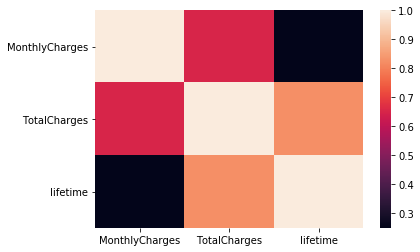

In [41]:
corr = df_num[['MonthlyCharges' , 'TotalCharges', 'lifetime',]].corr()
sns.heatmap(corr)

**Выводы по графикам:**
  - ежемесячная плата распределена не нормально. Средняя плата ушедших клиентов больше действующих
  - суммарная плата распределена не нормально. Средняя суммарная плата действующих клиентов значительно больше средней суммарной платы от действующих клиентов.
  - много ушедших клиентов с небольшой общей платой, что говорит об их быстром уходе на 1-м месяце облуживания. Распределение клиентов с большей суммарной платой примерно одинаково как для ушедших так и не ушедших клиентов.
  - по распределению признаков можно предположить, что MonthlyCharges больше разделяет целевой признак, чем TotalCharges.

**Анализ аномалий и выбросов**

*MonthlyCharges*

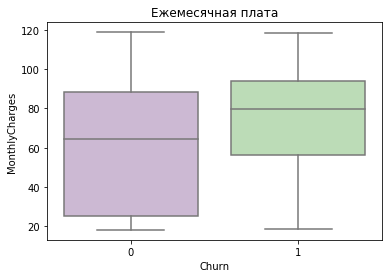

In [42]:
sns.boxplot(x="Churn", y="MonthlyCharges", data=df_num, palette="PRGn")
plt.title('Ежемесячная плата')
plt.show()

*TotalCharges*

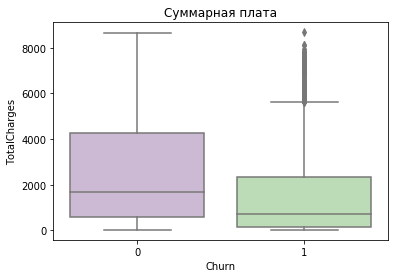

In [43]:
sns.boxplot(x="Churn", y="TotalCharges", data=df_num, palette="PRGn")
plt.title('Суммарная плата')
plt.show()

Количество строк с выбросами для ушедших клиентов

In [44]:
df_contract[(df_contract['TotalCharges'] > 6000) & (df_contract['Churn']==1)].count()

customerID          88
BeginDate           88
EndDate             88
Type                88
PaperlessBilling    88
PaymentMethod       88
MonthlyCharges      88
TotalCharges        88
Churn               88
lifetime            88
dtype: int64

In [45]:
data_outliers = df_contract[(df_contract['TotalCharges'] > 6000) & (df_contract['Churn']==1)]
df_contract.drop(data_outliers.index).reset_index(drop = True)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
6950  6840-RESVB 2018-02-01 2020-02-01        One year              Yes   
6951  2234-XADUH 2014-02-01 2020-02-01        One year              Yes   
6952  4801-JZAZL 2019-03-01 2020-02-01  Month-to-month              Yes   
6953  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   
6954  3186-AJIEK 2014-08-01 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  lifetime  
0              Electronic check           29.85         29.85      0        31  
1                  Mailed check           56.95       1889.50      0      1036  
2                  Mailed check           53.85        108.15      1        61  
3     Bank transfer (automatic)           42.30       1840.75      0      1371  
4              Electronic check           70.70        151.65      1        61  
...                         ...             ...           ...    ...       ...  
6950               Mailed check           84.80       1990.50      0       730  
6951    Credit card (automatic)          103.20       7362.90      0      2191  
6952           Electronic check           29.60        346.45      0       337  
6953               Mailed check           74.40        306.60      1       123  
6954  Bank transfer (automatic)          105.65       6844.50      0      2010  

[6955 rows x 10 columns]

Функция удаления выбросов. Убираем значения TotalCharges большие 6000 для ушедших клиентов.

In [46]:
def outliers(data):    
    data_outliers = data[(data['TotalCharges'] > 6000) & (data['Churn']==1)]
    data = data.drop(data_outliers.index).reset_index(drop= True)
    return data

**Анализ категориальных признаков**

В анализе категорианльных признаков рассмотрим основные:
- периодичность оплаты;
- тип оплаты;
- пол;
- пожилой/ не пожилой человек



Для анализа объединяем все признаки в один датафрейм. Предполагаем, что отсутствие по клиенту информации об услугам интернета и телефона означает, что такими услугами он не пользуется, значит пропуски заполняем значение 'No'

In [47]:
def merging(df_1, df_2, df_3, df_4):
    df_full= df_1.merge(df_2, how = 'left', on = 'customerID')
    df_full = df_full.merge(df_3, how = 'left', on = 'customerID')
    df_full = df_full.merge(df_4, how = 'left', on = 'customerID')
    df_full = df_full.fillna('No')
    return df_full

In [48]:
def pie_plot(data , column , title):
    df_plt_pie_0 = data.loc[df_contract['Churn']==0 , column]
    df_plt_pie_1 = data.loc[df_contract['Churn']==1 , column]

    colors = ['grey','blue','red','yellow','green','brown']
    
    sizes_0 = df_plt_pie_0.value_counts().values
    sizes_1 = df_plt_pie_1.value_counts().values
    labels_0 = df_plt_pie_0.value_counts().index
    labels_1 = df_plt_pie_1.value_counts().index
    explode = [0] *len(sizes_0)
    title_0 = title + ' действующих клиентов'
    title_1 = title + ' ушедших клиентов'

    f, (ax1, ax2)= plt.subplots(ncols=2 , sharey = True , figsize = (15,7))
    
    ax1.pie(sizes_0, explode=explode, labels=labels_0, colors=colors, autopct='%1.1f%%')
    ax1.set_title(title_0 ,color = 'blue',fontsize = 15)

    ax2.pie(sizes_1, explode=explode, labels=labels_1, colors=colors, autopct='%1.1f%%')
    ax2.set_title(title_1,color = 'blue',fontsize = 15)
    plt.show()

In [49]:
df_full = merging(df_contract, df_personal, df_phone, df_internet)

df_full.head()

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  Churn  lifetime  \
0           Electronic check           29.85         29.85      0        31   
1               Mailed check           56.95       1889.50      0      1036   
2               Mailed check           53.85        108.15      1        61   
3  Bank transfer (automatic)           42.30       1840.75      0      1371   
4           Electronic check           70.70        151.65      1        61   

   ... Partner  Dependents MultipleLines InternetService OnlineSecurity  \
0  ...     Yes          No            No             DSL             No   
1  ...      No          No            No             DSL            Yes   
2  ...      No          No            No             DSL            Yes   
3  ...      No          No            No             DSL            Yes   
4  ...      No          No            No     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  
0          Yes               No          No          No              No  
1           No              Yes          No          No              No  
2          Yes               No          No          No              No  
3           No              Yes         Yes          No              No  
4           No               No          No          No              No  

[5 rows x 22 columns]

In [50]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   lifetime          7043 non-null   int32         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  MultipleLines     7043 n

##### Периодичность оплаты  Type

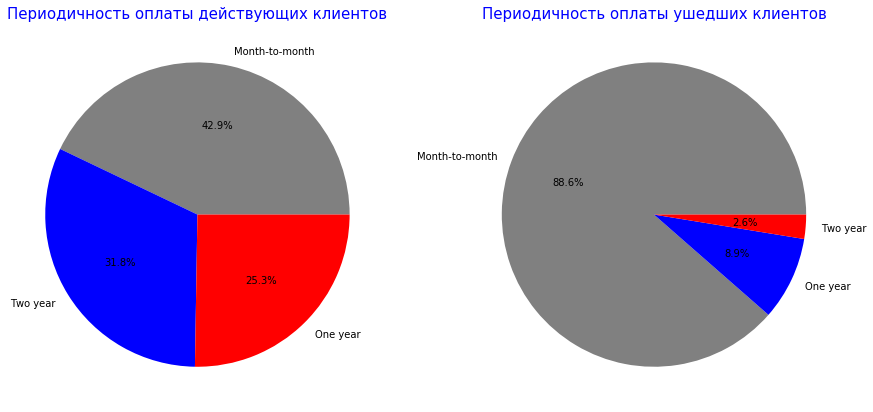

In [51]:
pie_plot(df_full, 'Type', 'Периодичность оплаты')

##### Тип оплаты PaymentMethod

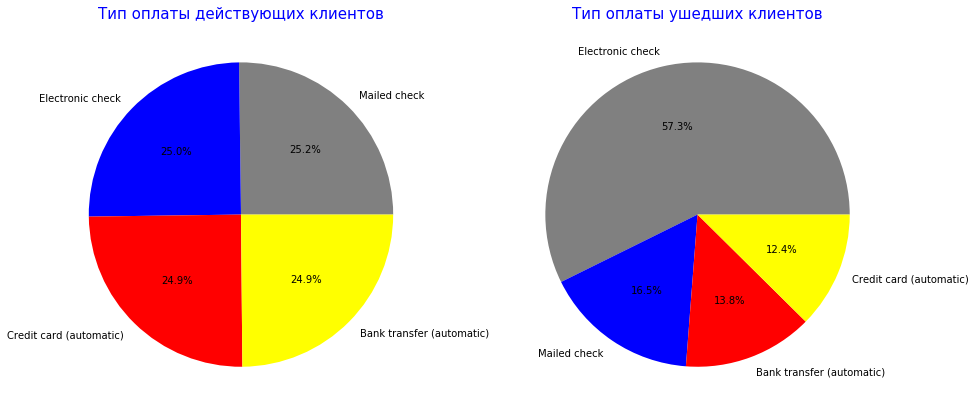

In [52]:
pie_plot(df_full, 'PaymentMethod', 'Тип оплаты')

##### Пол клиента gender

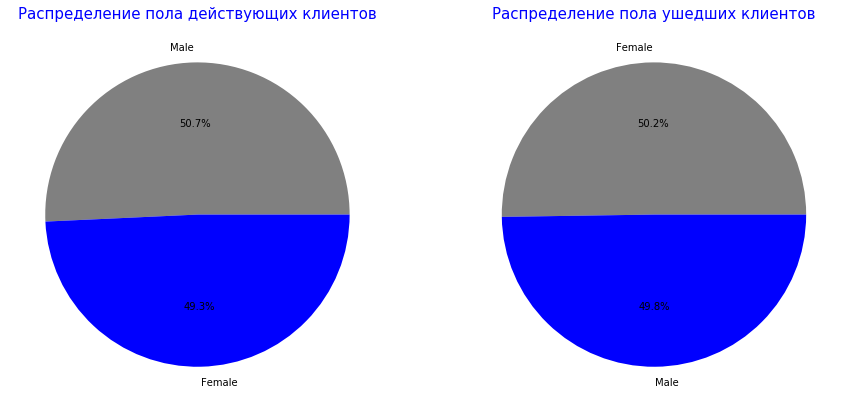

In [53]:
pie_plot(df_full, 'gender', 'Распределение пола')

##### Пожилой/ не пожилой человек  SeniorCitizen     

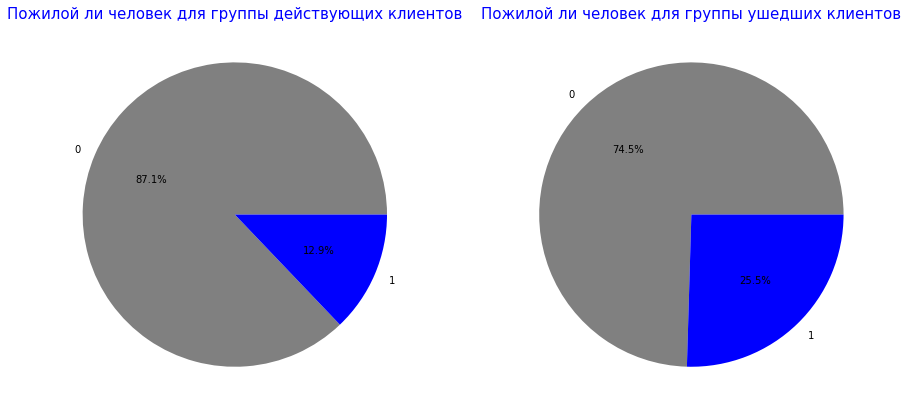

In [54]:
pie_plot(df_full, 'SeniorCitizen', 'Пожилой ли человек для группы')

Вывод:
- По результатам рассмотрения признаков можно сделать вывод, что пол не влияет на факт ухода клиента и его можно исключить из рассмотрения. 
- Отношение человека к группе пожилых людей также не значительно влияет на уход. 
Остальные признаки влияют на уход клиента.

**Декодируем и масштабируем признаки**

In [82]:
# Выбираем лучшие признаки из selectkbest
selected_cols = best_model.steps[0][1].get_support()

# названия признаков в список
selected_features = X.columns[selected_cols]

In [83]:
# Из модели получены значения влияния признака
feature_importances = best_model.steps[1][1].feature_importances_
feature_importances

array([ 0.34209287,  1.36206187,  6.05526822,  0.43298967,  0.23328216,
        0.7879053 ,  0.1436946 ,  0.15364502,  0.15216107,  1.80281977,
        0.80053475,  0.18084534,  0.11805555,  0.0873651 ,  0.45341418,
        0.19037589,  4.39097947, 10.4022462 , 71.80246388,  0.10779908])

In [84]:
# Создаем датафрейм с результатми
df_importance = pd.DataFrame(data = feature_importances , index = selected_features)
df_importance.columns = ['feature_importances']

In [85]:
df_importance.sort_values(by = 'feature_importances' , ascending=False)

feature_importances
lifetime                                         71.802464
TotalCharges                                     10.402246
Type_Two year                                     6.055268
MonthlyCharges                                    4.390979
InternetService_Fiber optic                       1.802820
Type_One year                                     1.362062
InternetService_No                                0.800535
PaymentMethod_Electronic check                    0.787905
TechSupport_Yes                                   0.453414
PaperlessBilling_Yes                              0.432990
SeniorCitizen                                     0.342093
PaymentMethod_Credit card (automatic)             0.233282
StreamingTV_Yes                                   0.190376
OnlineSecurity_Yes                                0.180845
Partner_Yes                                       0.153645
Dependents_Yes                                    0.152161
PaymentMethod_Mailed check                        0.143695
OnlineBackup_Yes                                  0.118056
is_family                                         0.107799
DeviceProtection_Yes                              0.087365

**Вывод по обучению и выбору модели:**
- выборка разделена 80% обучающих данных и  20% тестовых данных. Т.к. классы не сбалансированы выборки стратифицированные.
- для выбора признаков применен метод SelectKbest(). Выбраны 15 признаков.
- для лучшей модели лучшими признаками являются время жизни клиента, общие расходы клиента, и двухлетний договор.
- рассмотрены модели Random Forest , бустинги: XGBoost, LightFBM , CatBoost.
- методом Randomizedsearch выполнен поиск гиперпараметров.
- на обучении (кроссвалидация на 5 фолдах) лучшее значение целевой метрики AUC ROC  показала модель CatBoost.
- на основании этих данных далее можно определить вероятность ухода клиента и соответственно определить расходы, чтобы удержать клиента.

## 5. Тест модели

In [86]:
y_pred_test = best_model.predict(X_test)

y_score_test = best_model.predict_proba(X_test)

Precision score: 0.6674
Recall score:    0.9017
Accuracy score:  0.8598
ROC-AUC score:   0.8735


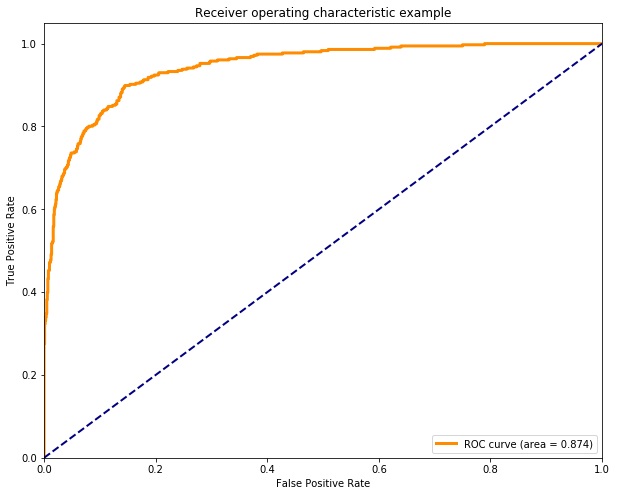

In [87]:
metrics(y_test, y_pred_test,y_score_test)

**Вывод по тесту модели:**
- на лучшей модели значение ROC AUC составляет 0.874


### Определение ID клиентов, которые могут уйти

In [88]:
list_features = np.append(selected_features, ('Churn'))

# Смоделированные признаки всех клиентов
df_selected = df_encoded[list_features]

# Признаки действующих клиентов
df_0 = df_selected[df_selected['Churn']==0].reset_index(drop=True)

# Признаки действующих клиентов
X_check = df_0.drop('Churn' , axis = 1)

# достаем модель из пайплайна
final_model =  best_model.steps[1][1]

# Предсказываем уход действующих клиентов
predicts = final_model.predict(X_check)     # Предсказания
probas = final_model.predict_proba(X_check) # Вероятности классов

In [89]:
df_churn = pd.DataFrame({'Churn_predicted': predicts, 'Churn_prob': np.around(probas[:,1]*100,2) } )
df_churn['Churn_predicted'].value_counts()

0    4452
1     722
Name: Churn_predicted, dtype: int64

In [91]:
df_churn[df_churn['Churn_predicted']==1]

Churn_predicted  Churn_prob
0                   1       88.60
9                   1       74.00
23                  1       80.18
31                  1       53.65
46                  1       54.06
...               ...         ...
5141                1       64.46
5142                1       72.64
5151                1       56.25
5152                1       78.95
5163                1       70.45

[722 rows x 2 columns]

In [92]:
df_pred = pd.concat([df_encoded[df_encoded['Churn']==0].reset_index(drop=True),df_churn], axis=1)
churn_customer_id = df_pred.loc[df_pred['Churn_predicted']==1,'customerID']

# ID клиентов, которые могут уйти
df_contract[df_contract['customerID'].isin(churn_customer_id)]

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
14    5129-JLPIS 2018-01-01 2020-02-01  Month-to-month              Yes   
34    3413-BMNZE 2020-01-01 2020-02-01  Month-to-month               No   
45    3714-NTNFO 2016-01-01 2020-02-01  Month-to-month              Yes   
65    5122-CYFXA 2019-11-01 2020-02-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
6997  2523-EWWZL 2017-11-01 2020-02-01  Month-to-month              Yes   
6998  0928-XUTSN 2019-01-01 2020-02-01  Month-to-month              Yes   
7014  9053-EJUNL 2016-09-01 2020-02-01  Month-to-month              Yes   
7015  0666-UXTJO 2017-04-01 2020-02-01  Month-to-month              Yes   
7029  2235-DWLJU 2019-08-01 2020-02-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  lifetime  
0              Electronic check           29.85         29.85      0        31  
14             Electronic check          105.50       2686.05      0       761  
34    Bank transfer (automatic)           45.25         45.25      0        31  
45             Electronic check           84.50       3906.70      0      1492  
65             Electronic check           75.30        244.10      0        92  
...                         ...             ...           ...    ...       ...  
6997           Electronic check           76.10       2093.40      0       822  
6998           Electronic check           80.50       1011.80      0       396  
7014           Electronic check           89.20       3645.75      0      1248  
7015    Credit card (automatic)           85.20       2874.45      0      1036  
7029           Electronic check           44.40        263.05      0       184  

[722 rows x 10 columns]

Вывод: 
Всего 722 клиента, которые с вероятностью более 50% могут нас покинуть. В дальнейшем можно определить методику, по которой с учетом вероятности ухода определить расходы на клиента, чтобы его сохранить.

## 6. Отчет по работе

1. Все пункты плана выполнены, а именно:
    - Определен целевой признак.
    - Проведен исследовательский анализ (EDA). 
    - Определена метрика, по которой выбиралась лучшая модель
    - Определены признаки, которые использовались для обучения модели.
    - Определен состав обучающей и тестовой выборок. 
    - Рассмотрены 4 модели (Random Forest , XGBoost, LightGBM, CatBoost),  из которых выбрана лучшая модель CatBoost.
    - С помощью модели определены действующие клиенты , которые могут уйти.
    - выводы сделаны по каждому разделу.
2. Трудности возникали с оптимизацией гиперапараметров моделей, но с помощью технической документации их достаточно быстро можно преодолеть.
3. Ключевые шаги в решении задачи это:
    - подоготовка данных для анализа. Например, удаление выбросов в количественном признаке позволило улучшить качество моделей.
    - оптимизация гиперпараметров для поиска лучшего решения.
    - (главное для заказчика работы) определение клиентов, которые вероятно могут уйти.
4. Итоговая модель - CatBoost, ROC AUC = 0.874